# Alexander Sørloth vs Thierno Barry - PCA Similarity Analysis
## Villarreal - Delantero Centro

**Context:**
- Alexander Sørloth: Fichado por Villarreal 10M€ (verano 2023) → vendido Atlético 32M€ (verano 2024)
- Thierno Barry: Fichado por Villarreal 11M€ (verano 2024)
- Position: ST (Striker)
- Analysis: PCA-based similarity algorithm to validate Barry as Sørloth replacement
- **Data analyzed: Season 23/24** (Sørloth: Villarreal 2489 min, Barry: Basel 2384 min)
- **CRITICAL**: Swiss Super League tiene solo **44 métricas** (vs 145 Big5) → PCA usa **26 métricas comunes** (Swiss ∩ Big5) en lugar de todas

In [1]:
import pandas as pd
import numpy as np
import sys
import os

# Subir tres niveles desde tfm/teams/villarreal/ hasta data/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

from database.connection import get_db_manager
from tfm.helpers.query_helpers import query_player_pool, add_exogenous_player
from tfm.helpers.algorithms import find_similar_players_cosine
from sqlalchemy import text

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Build player pool: FW from Big 5 + Swiss Super League (23/24 season)
big5_leagues = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']

pools = []
for league in big5_leagues:
    try:
        pool = query_player_pool(
            league=league,
            season='2324',
            positions=['ST'],
            max_market_value=15_000_000,
            min_minutes=1200,
            max_age=24,
            min_age=20
        )
        pools.append(pool)
        print(f"{league}: {len(pool)} jugadores")
    except Exception as e:
        print(f"Error en {league}: {e}")

# Add Swiss Super League (table_type='extras', season '2324')
try:
    pool_swiss = query_player_pool(
        league='SUI-Super League',
        season='2324',
        positions=['ST'],
        max_market_value=15_000_000,
        min_minutes=1200,
        max_age=24,
        min_age=20,
        table_type='extras'
    )
    pools.append(pool_swiss)
    print(f"SUI-Super League: {len(pool_swiss)} jugadores")
except Exception as e:
    print(f"Error en Swiss: {e}")

pool_df = pd.concat(pools, ignore_index=True)

print(f"\nPool total: {len(pool_df)} jugadores")
print(f"\nDistribución por liga:")
print(pool_df['league'].value_counts())

2025-12-31 15:21:29,522 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-12-31 15:21:32,196 - database.connection - INFO - Database connection successful
2025-12-31 15:21:32,347 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-12-31 15:21:32,398 - database.connection - INFO - Database connection successful
2025-12-31 15:21:32,450 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-12-31 15:21:32,483 - database.connection - INFO - Database connection successful
2025-12-31 15:21:32,545 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev


ENG-Premier League: 3 jugadores
ESP-La Liga: 2 jugadores
ITA-Serie A: 5 jugadores


2025-12-31 15:21:32,581 - database.connection - INFO - Database connection successful
2025-12-31 15:21:32,633 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-12-31 15:21:32,666 - database.connection - INFO - Database connection successful
2025-12-31 15:21:32,729 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-12-31 15:21:32,767 - database.connection - INFO - Database connection successful


GER-Bundesliga: 4 jugadores
FRA-Ligue 1: 5 jugadores
SUI-Super League: 10 jugadores

Pool total: 29 jugadores

Distribución por liga:
league
SUI-Super League      10
ITA-Serie A            5
FRA-Ligue 1            5
GER-Bundesliga         4
ENG-Premier League     3
ESP-La Liga            2
Name: count, dtype: int64


In [3]:
# Add Alexander Sørloth as exogenous player (target)
full_df = add_exogenous_player(
    pool_df=pool_df,
    player_name='Alexander Sørloth',
    league='ESP-La Liga',
    season='2324',
    team='Villarreal'
)

print(f"DataFrame con Target: {len(full_df)} jugadores")

2025-12-31 15:21:32,840 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-12-31 15:21:32,880 - database.connection - INFO - Database connection successful


Added exogenous player: Alexander Sørloth (Villarreal, ESP-La Liga 2324)
Total players in DataFrame: 30
DataFrame con Target: 30 jugadores


In [4]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    if value is None or pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.strip() == '' or value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    return np.nan

fbref_nums = extract_metrics(full_df, 'fbref_metrics')
understat_nums = extract_metrics(full_df, 'understat_metrics')
transfermarkt_nums = extract_metrics(full_df, 'transfermarkt_metrics')

print(f"FBref: {fbref_nums.shape[1]} métricas")
print(f"Understat: {understat_nums.shape[1]} métricas")
print(f"Transfermarkt: {transfermarkt_nums.shape[1]} campos")

FBref: 185 métricas
Understat: 10 métricas
Transfermarkt: 2 campos


In [5]:
# SWISS SUPER LEAGUE: solo 44 métricas vs 145 Big5
# Usar SOLO métricas comunes Swiss ∩ Big5 (26 relevantes)

# Métricas CORE que existen en ambas ligas (Swiss y Big5)
common_metrics_core = [
    'goals', 'assists', 'shots', 'shots_on_target', 'non_penalty_goals',
    'goals_plus_assists', 'penalty_goals', 'penalty_attempts',
    'goals_per_shot', 'goals_per_shot_on_target',
    'SoT/90', 'shots_per_90', 'G+A-PK',
    'Fld', 'Crs', 'interceptions', 'tackles_won', 'Tackles_TklW',
    'Fls', 'Off'
]

# Normalizar per90 solo las que NO son ya ratios
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy',
    # Ya son ratios o per90
    'goals_per_shot', 'goals_per_shot_on_target', 'SoT/90', 'shots_per_90',
    'G+A-PK', 'shots_on_target_pct'
}

# Seleccionar solo métricas comunes
fbref_common = fbref_nums[[col for col in common_metrics_core if col in fbref_nums.columns]]

# Normalizar per90 las que lo necesitan
fbref_to_normalize = fbref_common.loc[:, ~fbref_common.columns.isin(exclude_normalization)]
fbref_per90 = (fbref_to_normalize.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

# Mantener ratios sin normalizar
fbref_ratios = fbref_common[[col for col in fbref_common.columns if col in exclude_normalization]]

print(f"Métricas comunes: {len(common_metrics_core)}")
print(f"Normalizadas per90: {fbref_per90.shape[1]}")
print(f"Ratios sin normalizar: {fbref_ratios.shape[1]}")

Métricas comunes: 20
Normalizadas per90: 15
Ratios sin normalizar: 5


In [6]:
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    full_df[base_cols],
    fbref_per90,
    fbref_ratios
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} jugadores × {df_final.shape[1]} columnas")
print(f"Métricas para PCA: {fbref_per90.shape[1] + fbref_ratios.shape[1]} (Swiss ∩ Big5 common)")

DataFrame final: 30 jugadores × 26 columnas
Métricas para PCA: 20 (Swiss ∩ Big5 common)


In [7]:
# Identify target (Sørloth) and replacement (Barry)
target = df_final[df_final['player_name'].str.contains('Sørloth', case=False, na=False) | 
                  df_final['player_name'].str.contains('Sorloth', case=False, na=False)]
target = target[target['team'].str.contains('Villarreal', case=False, na=False)]

replacement = df_final[df_final['player_name'].str.contains('Barry', case=False, na=False)]
replacement = replacement[replacement['team'].str.contains('Basel', case=False, na=False)]

if len(target) == 0:
    raise ValueError("Target no encontrado")
if len(replacement) == 0:
    raise ValueError("Replacement no encontrado")

target_id = target.iloc[0]['unique_player_id']
replacement_id = replacement.iloc[0]['unique_player_id']

print(f"Target: {target.iloc[0]['player_name']} ({target.iloc[0]['team']})")
print(f"  ID: {target_id}")
print(f"\nReemplazo: {replacement.iloc[0]['player_name']} ({replacement.iloc[0]['team']})")
print(f"  ID: {replacement_id}")

Target: Alexander Sørloth (Villarreal)
  ID: cad28b020b20f985

Reemplazo: Thierno Barry (Basel)
  ID: 260b2b815532355b


In [8]:
# Run PCA similarity algorithm
result = find_similar_players_cosine(
    df=df_final,
    target_player_id=target_id,
    n_similar=30,
    pca_variance=0.85,
    replacement_id=replacement_id,
    robust_scaling=False
)

Target: Alexander Sørloth (Villarreal, ESP-La Liga)
Features: 15 (per 90, excl. GK)
Jugadores: 30 (eliminados 0 con NaNs CORE)
PCA: 6 componentes (varianza: 89.2%)
Reducción: 15 → 6 dimensiones
Top-30 encontrados
Rango similitud: [-0.7223, 0.7560]


Visualización generada: /home/jaime/FD/data/tfm/teams/villarreal/sorloth_barry_top10_ranking.png


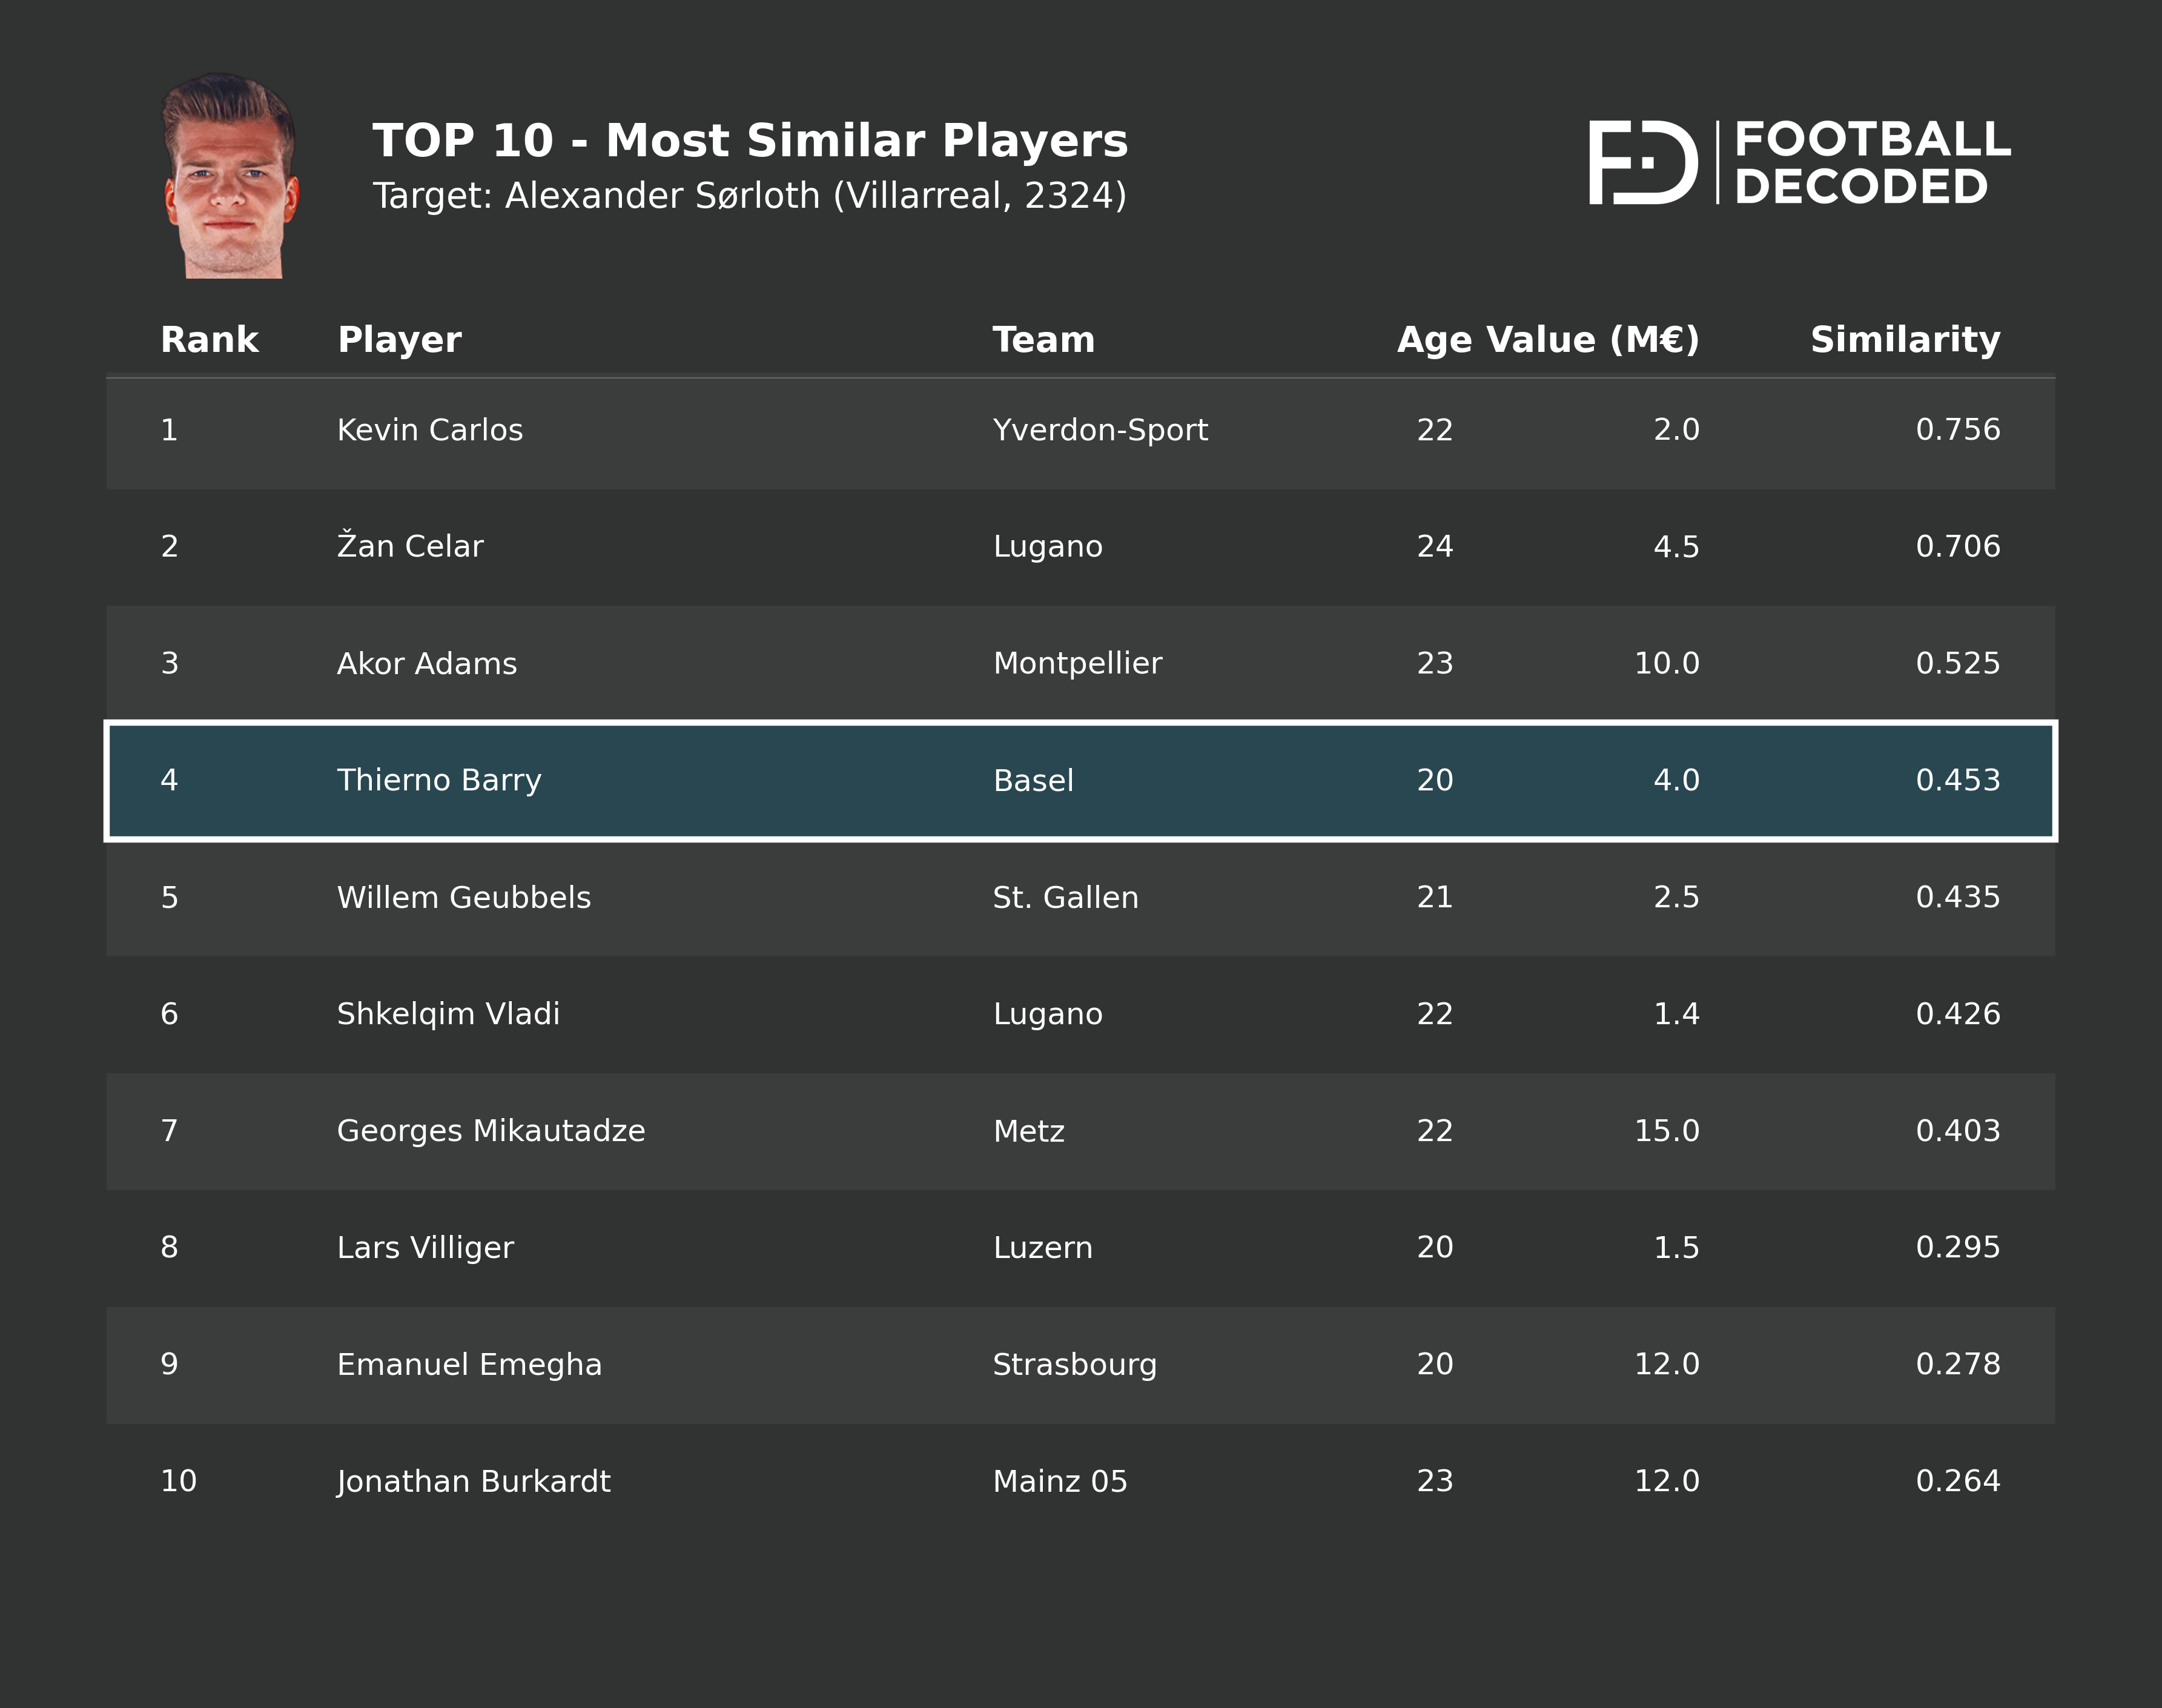

In [9]:
from tfm.helpers.viz_helpers import plot_top10_ranking

output_path = plot_top10_ranking(
    result=result,
    df_data=full_df,
    save_path='sorloth_barry_top10_ranking.png',
    target_face_path='/home/jaime/FD/data/blog/caras/tfm/sorloth.png',
    highlight_target=True,
    dpi=300
)

print(f"Visualización generada: {output_path}")

from IPython.display import Image, display
display(Image(filename=output_path))

In [10]:
# PCA Information
pca_info = result['pca_info']

print("\nINFORMACIÓN PCA")
print("="*80)
print(f"Dimensiones originales: {pca_info['original_dimensions']}")
print(f"Componentes retenidos: {pca_info['n_components']}")
print(f"Varianza explicada: {pca_info['explained_variance_ratio']:.1%}")
print(f"Ratio de compresión: {pca_info['compression_ratio']:.1%}")
print("\nVarianza por componente (top-5):")
for i, var in enumerate(pca_info['top_5_components_variance'], 1):
    print(f"  PC{i}: {var:.1%}")


INFORMACIÓN PCA
Dimensiones originales: 15
Componentes retenidos: 6
Varianza explicada: 89.2%
Ratio de compresión: 40.0%

Varianza por componente (top-5):
  PC1: 43.4%
  PC2: 15.0%
  PC3: 10.0%
  PC4: 9.2%
  PC5: 6.9%


In [11]:
# Similarity Score Distribution
dist = result['score_distribution']

print("\nDISTRIBUCIÓN DE SIMILITUDES")
print("="*80)
print(f"Mínimo:   {dist['min']:.4f}")
print(f"Q5:       {dist['q5']:.4f}")
print(f"Q25:      {dist['q25']:.4f}")
print(f"Mediana:  {dist['median']:.4f}")
print(f"Q75:      {dist['q75']:.4f}")
print(f"Q95:      {dist['q95']:.4f}")
print(f"Máximo:   {dist['max']:.4f}")
print(f"Media:    {dist['mean']:.4f}")
print(f"Desv.Est: {dist['std']:.4f}")


DISTRIBUCIÓN DE SIMILITUDES
Mínimo:   -0.7223
Q5:       -0.6750
Q25:      -0.3926
Mediana:  -0.1410
Q75:      0.2948
Q95:      0.6336
Máximo:   0.7560
Media:    -0.0517
Desv.Est: 0.4460
